## Part 1 - Dimensionality Reduction and Feature Selection


Thinking in high dimensions is particularly hard. A 1-D dot would hardly be able to imagine a 2D world. In the same way, the square below struggles to think of our 3D world. For us, it is very difficult to imagine dimensions above the 3rd. We have proxies for thinking of a 4th dimension - passing of time, a 3D surface with some extra measure represented by color, etc - but this starts to become really difficult to work above the 4th dimension.  

![dimensionality](./media/flatland.png)

Thankfully, when dealing with ML problems, you can go above three features without trying to imagine how they would look like (Lucky you!). However, you still need to understand how the number of dimensions might affect - either positively or negatively - your models and how to work with high dimensional spaces. Don't worry, we will guide you through it.

In [1]:
import string
import re
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pylab import barh,plot,yticks,show,grid,xlabel,figure,cla,close
from nltk.tokenize import WordPunctTokenizer

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2

## 1. The curse of dimensionality

So far you learned how to handle text data by transforming it into a vectorized feature space. Namely, we mostly used preprocessing tricks and some sort of count over words - remember the CountVectorizer and TF-IDF - to generate our feature space. However, as you might have realized, the number of features for these problems is huge, in particular if you want to cover all language. In the limit, your feature space will cover the entire vocabulary!


The effect of high dimensionality features when modelling these problems is called the **curse of dimensionality**. You can probably already see some of the effects of these curse, right?

* To start with, more features, will obviously mean a longer training process
* On another hand, a higher dimensionality can actually hurt the classifier performance



#### But I thought "more features" meant "more accuracy"...

This is not always true. When you have high dimensionality problems, the use of all the features might actually hurt your model. The model becomes more prone to overfitting and might have worse accuracy in points outside your training data.


## 2.  Basic Feature Selection

One of the ways you might think of to reduce your feature dimensionality is by performing feature selection. We are going to walk you through some methods with an actual example. Let's start by loading some data - we are going to use the twitter dataset of republican and democrat tweets

### 2.1 - Get your dataset

Start by importing the dataset. 

In [2]:
df = pd.read_csv('./datasets/twitter_rep_dem_data_small.csv')
df

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...
...,...,...,...
18514,Republican,RepTomPrice,Check out my op-ed on need for End Executive O...
18515,Republican,RepTomPrice,"Yesterday, Betty &amp; I had a great time lear..."
18516,Republican,RepTomPrice,We are forever grateful for the service and sa...
18517,Republican,RepTomPrice,Happy first day of school @CobbSchools! #CobbB...


### 2.2 - Get to know our problem 

We'll first learn our categories and see a few examples of how our training data looks like. 

In [3]:
print('Categories:')
print(', '.join(set(df.Party)))

Categories:
Democrat, Republican


Check class balances

In [4]:
df.Party.value_counts()

Republican    9302
Democrat      9217
Name: Party, dtype: int64

Pretty balanced!

In [5]:
df.head(10)

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...
5,Democrat,RepDarrenSoto,RT @EmgageActionFL: Thank you to all who came ...
6,Democrat,RepDarrenSoto,Hurricane Maria left approx $90 billion in dam...
7,Democrat,RepDarrenSoto,RT @Tharryry: I am delighted that @RepDarrenSo...
8,Democrat,RepDarrenSoto,RT @HispanicCaucus: Trump's anti-immigrant pol...
9,Democrat,RepDarrenSoto,RT @RepStephMurphy: Great joining @WeAreUnidos...


You'll notice that our tweets are just text with some particularities. For example, it is common to have twitter handles in the text, defined by the "@" character. Our data also has three columns, but we are going to ignore the *Handle* column for now and just focus on classifying *Tweets* with *Party* labels.

### 2.3 - Feature Extraction

Our data is simply raw text, each element a document to be classified, with a corresponding label, which is the Party of the tweet. Pretty simple, right?

Since you are a great student, you went thoroughly through BLU07 and you already know how to prepare, handle text and extract some simple features. So let's process our data and use TfidfVectorizer with a range of 1-2 ngrams to get us some simple features.

First let's apply simple tokenization. To avoid overfitting to twitter related information, like the handles tagged in the messages, let's remove those, so our focus is only on the language.

In [6]:
handle_removal = lambda doc: re.subn(r'@\w+','', doc.lower())[0]
df['Tweet'] = df['Tweet'].map(handle_removal)

simple_tokenizer = lambda doc: " ".join(WordPunctTokenizer().tokenize(doc))
df['Tweet'] = df['Tweet'].map(simple_tokenizer)

df.head(10)

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"today , senate dems vote to # savetheinternet ..."
1,Democrat,RepDarrenSoto,rt : winter haven resident / alta vista teache...
2,Democrat,RepDarrenSoto,rt : . noted that hurricane maria has left app...
3,Democrat,RepDarrenSoto,rt : meeting with . thanks for taking the time...
4,Democrat,RepDarrenSoto,rt : hurricane season starts on june 1st ; pue...
5,Democrat,RepDarrenSoto,rt : thank you to all who came out to our orla...
6,Democrat,RepDarrenSoto,hurricane maria left approx $ 90 billion in da...
7,Democrat,RepDarrenSoto,rt : i am delighted that will be voting for th...
8,Democrat,RepDarrenSoto,rt : trump ' s anti - immigrant policies are h...
9,Democrat,RepDarrenSoto,rt : great joining and for a roundtable in # o...


Now let's split our data and apply some vectorization. Let's pick a random seed so the results are replicable.

In [7]:
seed = 42

<img src="./media/random.jpg" width="400">

In [30]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=seed)

print('Training examples: {}'.format(train_data.size))
print('Test examples: {}\n'.format(test_data.size))

# important: only train the vectorizer on the training data
vectorizer = TfidfVectorizer(ngram_range=(1,2))
%timeit vectorizer.fit(train_data.Tweet)

X_train = vectorizer.transform(train_data.Tweet)
X_test = vectorizer.transform(test_data.Tweet)

y_train = train_data.Party
y_test = test_data.Party

Training examples: 38889
Test examples: 16668

1.39 s ± 28.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 2.4 - Getting our baseline

Let's get our baseline accuracy and measure the time it takes to fit a Naive Bayes Model, a model you should be familiar with and which in NLP comes hand in hand with the Bag Of Words representation (if you don't get the joke below, eventually you should go read about naive bayes).

<img src="./media/frequentists_vs_bayesians_2x.png" width="400">



In [9]:
clf =  MultinomialNB()
%timeit clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(y_pred, y_test)))

29.7 ms ± 575 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7595392368610511


### 2.5 - Feature selection

Now that we have our baseline, let's start by looking into the number of features used in our classifier:

In [10]:
X_train.shape

(12963, 138409)

So far so good, and our classifier even trained pretty fast, but a 140K-dimensional space is obviously very difficult to interpret (think back to the fact that even 4D is difficult for us to grasp). Let's instead try to extract our K most important words. One way that you might think to do this is actually to just get the features corresponding to the most frequent terms. In fact, our TfidfVectorizer already has an option for that. Let's see the impact on our training speed and accuracy.

In [11]:
for k in [10, 100, 1000, 5000, 10000, 50000, 100000]:
    print('Using {} features'.format(k))
    print('----'.format(k))
    
    X_train = train_data.Tweet
    X_test = test_data.Tweet
    
    vectorizer_truncated = TfidfVectorizer(ngram_range=(1,2), max_features=k)
    vectorizer_truncated.fit(X_train)

    X_train_truncated = vectorizer_truncated.transform(X_train)
    X_test_truncated = vectorizer_truncated.transform(X_test)
    
    clf =  MultinomialNB()
    %timeit clf.fit(X_train_truncated, y_train)
    y_pred = clf.predict(X_test_truncated)
    
    print('Accuracy: {}\n'.format(accuracy_score(y_pred, y_test)))

Using 10 features
----
22.7 ms ± 278 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.5259179265658748

Using 100 features
----
23.9 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.5815334773218143

Using 1000 features
----
23.5 ms ± 614 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.6637868970482361

Using 5000 features
----
23.7 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7177825773938085

Using 10000 features
----
24.5 ms ± 332 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7341612670986322

Using 50000 features
----
26.5 ms ± 724 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7543196544276458

Using 100000 features
----
28.1 ms ± 503 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7543196544276458



Ok, so no amazing effects. Let's look into the actual top K-features to see if they make sense.

In [12]:
K=10
vectorizer_truncated = TfidfVectorizer(ngram_range=(1,2), max_features=K)
vectorizer_truncated.fit(X_train)
feature_names = vectorizer_truncated.get_feature_names()
for f in feature_names:
    print(f)

and
co
for
https
https co
in
of
rt
the
to


As you can see, the top 10 features are basically meaningless when thinking of our classes. In the next cell you will see that the counts of these words are balanced between classes.

In [13]:
sub_punct = lambda s: re.sub(r'\s+\W*[a-z]?\W*\s+', ' ', s)

In [14]:
for feature in feature_names:
    print('Documents that contain the word "{}"'.format(feature))
    print('----')
    docs = X_train.apply(sub_punct).str.lower().str.contains(feature)
    print(str(y_train[docs].value_counts()) + '\n\n')

Documents that contain the word "and"
----
Democrat      2410
Republican    2334
Name: Party, dtype: int64


Documents that contain the word "co"
----
Democrat      5571
Republican    5493
Name: Party, dtype: int64


Documents that contain the word "for"
----
Republican    2307
Democrat      2188
Name: Party, dtype: int64


Documents that contain the word "https"
----
Democrat      4818
Republican    4702
Name: Party, dtype: int64


Documents that contain the word "https co"
----
Democrat      4775
Republican    4616
Name: Party, dtype: int64


Documents that contain the word "in"
----
Republican    5103
Democrat      5101
Name: Party, dtype: int64


Documents that contain the word "of"
----
Democrat      2294
Republican    2235
Name: Party, dtype: int64


Documents that contain the word "rt"
----
Republican    2755
Democrat      2670
Name: Party, dtype: int64


Documents that contain the word "the"
----
Democrat      4191
Republican    4139
Name: Party, dtype: int64


Documents that c

Tip: Notice that most of these words are normally considered stopwords. Try to exclude stopwords from the TfidfVectorizer and see what new top features you obtain. You will probably see that there will be some common words and some "political discourse" words, but not really democrat/republican specific. 

But let's move on to more meaningful approaches.

## 3.  Feature Selection through statistical analysis

Basic feature selection methods might actually work sometimes, in particular if you pick a reasonable heuristic to decide on which features to choose. In our case, obviously, just picking the higher counts is not that good, since it does not provide any useful information on the labels. But you could imagine for example trying to pick as features words that appear only (or almost only) on one of our classes.

Although this might seem a good idea, depending on your problem, you would probably not want to lose that much time thinking about heuristics, implementing them and comparing them. This is where statistical tests are useful. You don't have to reason on the features you are using, these tests use your data to provide insights on your features.

##### Chi-squared test

The chi-squared test is one of these tests. The chi-squared formula measures how much expected counts and observed counts of variables/distributions deviate from each other. It can be used to test for independce between two variables, like defined by the equation below, where $O_{x_1x_2}$ is the observation of the conjuction of variables and $E_{x_1x_2}$ the corresponding expected value, this is, the expected value given our hypothesis *$H_0$: the variables are independent*.

$$\chi^2 = \sum{\frac{(O_{x_1x_2} - E_{x_1x_2})^2}{E_{x_1x_2}}}$$

For feature selection we want to test the independence of our features from the class labels. In our particular case, we define $x_1=t$ as our term or word and $x_2=c$ as our class label. A small chi-squared value will mean that the term is closer to independence from the class, and a big value that it is very dependent on the class.

Knowing the details of the chi-squared can be useful for you, but in the context of our BLU is not our primary goal and there are more useful methods for text features that you will learn about in the following notebooks. However, we provide at the end of this BLU a more detailed explanation of this test, and some examples, if you wish to understand it better (see Annex A).

We will lean on the previous example and show you how chi-squared would help us select more meaningful features.

## 3.1 - Setup problem

Like before, let's fetch our data, extract its features, run a baseline, and move from there.

In [23]:
stat_df = pd.read_csv('./datasets/twitter_rep_dem_data_small.csv')

stat_df['Tweet'] = stat_df['Tweet'].map(handle_removal)
stat_df['Tweet'] = stat_df['Tweet'].map(simple_tokenizer)

stat_train_data, stat_test_data = train_test_split(stat_df, test_size=0.3, random_state=seed)

stat_vectorizer = TfidfVectorizer(ngram_range=(1,2))
%timeit stat_vectorizer.fit(stat_train_data.Tweet)

stat_X_train = stat_vectorizer.transform(stat_train_data.Tweet)
stat_X_test = stat_vectorizer.transform(stat_test_data.Tweet)

stat_y_train = stat_train_data.Party
stat_y_test = stat_test_data.Party

stat_clf =  MultinomialNB()
%timeit stat_clf.fit(stat_X_train, stat_y_train)

stat_pred = stat_clf.predict(stat_X_test)

print('Accuracy: {}'.format(accuracy_score(stat_pred, stat_y_test)))

655 ms ± 66.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
27.9 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7595392368610511


## 3.2 - Feature Selection from chi-squared

We will now use the chi2 and obtain some chi-squared values for our features. 

In [24]:
chi_values, p_values = chi2(stat_X_train, stat_y_train)

We can plot the most dependent features from the chi-squared values.

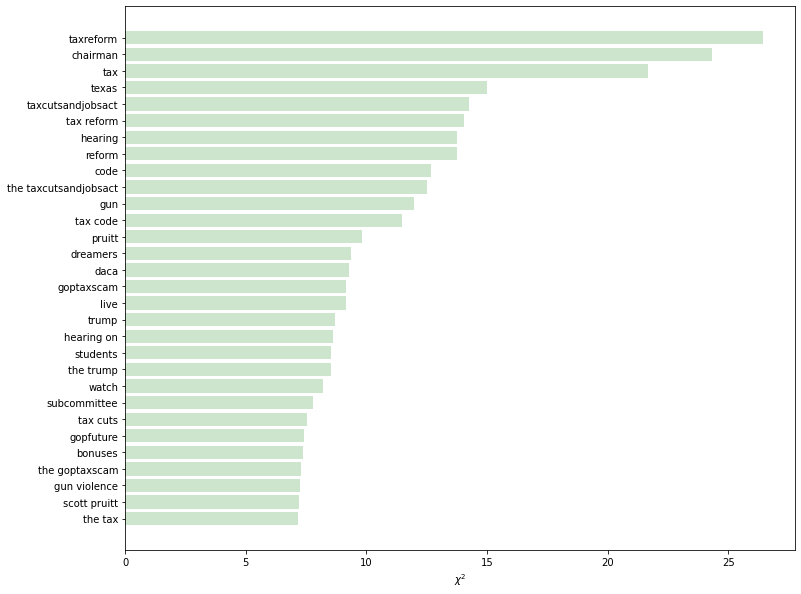

In [25]:
feature_names = stat_vectorizer.get_feature_names()

cla()   # Clear axis
close() # Close a figure window

figure(figsize=(12,10))
zipped_chi_squared = zip(feature_names, chi_values)
sorted_chi_values = sorted(zipped_chi_squared, key=lambda x:x[1]) 
top_chi_values = list(zip(*sorted_chi_values[-30:]))

x = range(len(top_chi_values[1]))
labels = top_chi_values[0]
barh(x, list(top_chi_values)[1], align='center', alpha=.2, color='g')
yticks(x, labels)
xlabel('$\chi^2$')
show()

Actually, scikit-learn already provides a function to directly select the K-best features for our model, so we are going to use that to extract our most important features. We can confirm that the top features selected match the ones with the highest chi-values

In [29]:
len(ch2.get_support(indices=True))

10

In [28]:
feature_names[23744]

'chairman'

In [26]:
ch2 = SelectKBest(chi2, k=10)
ch2.fit(stat_X_train, stat_y_train)

most_important_features = [feature_names[i] for i in ch2.get_support(indices=True)]
for f in most_important_features:
    print(f)

chairman
code
hearing
reform
tax
tax reform
taxcutsandjobsact
taxreform
texas
the taxcutsandjobsact


Now we're getting somewhere, these new features are starting to make sense. We can look into their distribution of  over our documents to get a sense of the relation they share with the labels of the dataset.

In [19]:
for feature in most_important_features:
    print('Documents that contain the word "{}"'.format(feature))
    print('----')
    docs = stat_train_data['Tweet'].apply(sub_punct).str.contains(feature)
    print(str(stat_y_train[docs].value_counts()) + '\n\n')

Documents that contain the word "chairman"
----
Republican    196
Democrat        8
Name: Party, dtype: int64


Documents that contain the word "code"
----
Republican    107
Democrat        8
Name: Party, dtype: int64


Documents that contain the word "hearing"
----
Republican    264
Democrat       62
Name: Party, dtype: int64


Documents that contain the word "reform"
----
Republican    426
Democrat       34
Name: Party, dtype: int64


Documents that contain the word "tax"
----
Republican    800
Democrat      217
Name: Party, dtype: int64


Documents that contain the word "tax reform"
----
Republican    126
Democrat        6
Name: Party, dtype: int64


Documents that contain the word "taxcutsandjobsact"
----
Republican    102
Name: Party, dtype: int64


Documents that contain the word "taxreform"
----
Republican    227
Democrat        2
Name: Party, dtype: int64


Documents that contain the word "texas"
----
Republican    121
Democrat        1
Name: Party, dtype: int64


Documents tha

As you can see, some words are much more common in Republican tweets compared to Democrat tweets. These features are thus much more interpretable and might have a better impact on training.

In [20]:
for k in [10, 100, 1000, 5000, 10000, 50000, 100000, 'all']:
    print('Using {} features'.format(k))
    print('----'.format(k))
    
    ch2_train = SelectKBest(chi2, k=k)
    ch2_train.fit(stat_X_train, stat_y_train)
    X_train_chi = ch2_train.transform(stat_X_train)
    X_test_chi = ch2_train.transform(stat_X_test)

    clf = MultinomialNB()
    %timeit clf.fit(X_train_chi, stat_y_train)

    y_pred = clf.predict(X_test_chi)

    print('Accuracy: {}\n'.format(accuracy_score(y_pred, stat_y_test)))



Using 10 features
----
22.9 ms ± 827 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.4744420446364291

Using 100 features
----
24.3 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.5984521238300936

Using 1000 features
----
23 ms ± 741 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.709143268538517

Using 5000 features
----
23.5 ms ± 462 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7321814254859611

Using 10000 features
----
24.4 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7368610511159107

Using 50000 features
----
26 ms ± 813 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7496400287976962

Using 100000 features
----
28.6 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7566594672426206

Using all features
----
30.4 ms ± 704 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7595392368610511



Using 100000 features we get only slightly better results. However, looking at the features themselves, we can clearly see this is a better feature selection method than the previous one, but we could still use a bit more gain and speed improvements.

One thing that feature selection does not take into consideration is feature interaction, which can limit a bit the gains in performance. In the remaining of this BLU you will learn about more elaborate methods to perform dimensionality reduction, in particular some very recent methods that are the standard in text-related tasks. 

## 4. Final remarks

After reading this notebook you should understand:

 - What is the curse of dimensionality
 - How can you perform simple feature selection by reasoning about your problem
 - How to apply statistical methods for feature selection by finding dependencies between features and labels
 
Keep in mind that predicting in the real world is much less theoretical. The performance of these methods will depend a lot on your problem, the size of your dataset, your model choice, your preprocessing. You can use feature selection to improve speed, avoid overfitting, or even just to interpret your features and how they interact with your classes. 

<br>

-----

**Suggestion**: try to vary the following options/parameters and analyze its impact:

- Experiment a bit more with your preprocessing and see its impact
- Try other feature extraction options such as the simple CountVectorizer
- Use smaller slices of the dataset to see how the dataset size impacts both baseline and feature selected results
- Experiment with other classifiers and the impact of the dimensionality reduction on them
- Try to use the model to evaluate other text data, search for republican/democrat posts/news/blogs and see how well your model classifies each, for example political speeches.

-----

<br>

Although we focused on simple heuristics and in the chi-squared method, there are other features selection methods that you might find useful. Some examples of these are:

- Feature selection through variance (sklearn.feature_selection.VarianceThreshold)
- Feature selection through mutual information
- Recursive feature elimination
- Tree-based feature selection

**And remember, these methods just tell us that there is a relation between labels and features, but not the nature of that relation.** Now go and apply these methods!

![correlation](./media/correlation.png)




-------------

## Annex A.  Details on chi-squared


Let's do a really quick example for you to understand how this works. Let's say we are modeling how characteristics from star trek characters that appear in an episode are related to their death, and among our features we have one particular called "has red t-shirt" which can take only two categorical values: Yes/No.

Let's build a table representing this scenario:

|  Has red t-shirt    | Dies   | Does not die | Total |
|----------------------|--------|--------------|-------|
|         Yes          |   63   |      9       |  72   |
|         No           |   13   |     40       |  53   |
|         total        |   76   |     49       |  125  |

This is what we call a contigency table, and it contains our observed values. Testing for independence of the variables, our expected value is computed from the probabilities $N*P(x_1x_2) = N*P(x_1)P(x_2) $, and we get:

|  Has red t-shirt    | Dies   | Does not die | 
|----------------------|--------|--------------|
|         Yes          |  43.78 $$(125 * \frac{76}{125}\frac{72}{125})$$ | 28.22 $$(125 * \frac{49}{125}\frac{72}{125})$$ |
|         No           |  32.22 $$(125 * \frac{76}{125}\frac{53}{125})$$ | 20.78 $$(125 * \frac{49}{125}\frac{53}{125})$$ |

Now we can use these expected values to compute chi-squared using the formula $\chi^2 = \sum{\frac{(O_{x_1x_2} - E_{x_1x_2})^2}{E_{x_1x_2}}}$

|  Has red t-shirt    | Dies   | Does not die | 
|----------------------|--------|--------------|
|         Yes          |  8.44 $$(\frac{(63-43.78)^2}{43.78})$$ | 13.09 $$(\frac{(9-28.22)^2}{28.22})$$ |
|         No           |  11.47 $$(\frac{(13-32.22)^2}{32.22})$$ | 17.79 $$(\frac{(40-20.78)^2}{20.78})$$ |

Summing these values, we get a chi-squared of 50.79, which corresponds to a p-value < .00001, which means we are dealing with dependent variables. 

<img src="./media/dig3graves.jpeg" width="500">


### Chi-squared in BoW context

But how about our context? Our variables are not categorical, so how do we compute this? Actually the chi-squared value can be extended to frequencies, building a contingency table from the feature values and class label. Starting from a table of word frequencies:


|                      |&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $C_0$ &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;   | ... | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $C_j $  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  | ... | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Total               |
|----------------------|---------------------|-----|-------------------------|-----|----------------------------|
|   Word 0             |  $$C_{t_0, c_0}$$   | ... |  $$C_{t_0, c_1}$$       | ... | $$ \sum_j{C_{t_0, c_j}} $$ |
|   Word 1             |  $$C_{t_1, c_0}$$   | ... |  $$C_{t_1, c_1}$$       | ... | $$ \sum_j{C_{t_1, c_j}} $$ |
|    ...               |   ...               | ... |     ...                 | ... |        ...                 |  
|   Word i             |  $$C_{t_i, c_0}$$   | ... |  $$C_{t_i, c_1}$$       | ... | $$ \sum_j{C_{t_i, c_j}} $$ |
|    ...               |   ...               | ... |     ...                 | ... |        ...                 |  
|   Total       | $$ \sum_i{C_{t_i, c_0}} $$ | ... |$$\sum_i{C_{t_i, c_j}} $$| ... | $$ N = \sum_{i,j}{C_{t_i, c_j}} $$|  


We can take each feature ($t=x_i$) and class ($c=c_j$) and assume a table of the form:

|                      | Class j   | Not Class j |  Total | 
|----------------------|-----------|-------------|--------|
|   Word i             |  $C_{tc}$ |   $C_{tx}$  |  $C_{tc}$ + $C_{tx}$ |
|   Not Word i         |  $C_{xc}$ |   $C_{xx}$  |  $C_{xc}$ + $C_{xx}$ | 
|   Total      |  $C_{tc}$ + $C_{xc}$ |   $C_{tx}$ + $C_{xx}$  |  N = $C_{tc}$ + $C_{xc}$ + $C_{tx}$ + $C_{xx}$ |

Where:

- $C_{tc}$ : counts of co-ocurrences of the term and class 
- $C_{tx}$ : counts of ocurrences of the term but not the class 
- $C_{xc}$ : counts of ocurrences of the class but not the term
- $C_{xx}$ : counts of ocurrences outside the class and without the term

<br>
Notice that you can compute your negative word counts ("Not Word i") by using the totals:

$$C_{xc} = \sum_i{C_{t_i, c}} - C_{tc}  \quad\quad C_{tx} = \sum_j{C_{t, c_j}} - C_{tc} \quad\quad C_{xx} = N - C_{tc} - C_{tx} - C_{xc} $$

<br>
The expression can be expanded to the following, for each term $t$ and class $c$:

$$\chi^2(t, c) = \frac{N(C_{tc}C_{xx}-C_{tx}C_{xc})^2}{(C_{tc}+C_{xc})(C_{tx}+C_{xx})(C_{tc}+C_{tx})(C_{xc}+C_{xx})}$$

<br>

-----

**Sugestion**: If, like me, you can't move forward without understanding the origin of these expressions, try to get from the initial expression to this expanded form. However, if you get stuck on the math, just go into the notebook **Learning Notebook - Optional - Chi-squared math** and follow the demonstration.

-----


<br>
And we will get for all our terms and classes the chi-squared values indication correlation

|                      | Republican ($C_0$)  | Democrat ($C_1$) |  
|----------------------|-----------|-------------|
|   Word 0             |  $$\chi^2(t_0, c_0)$$ |  $$\chi^2(t_0, c_1)$$ | 
|   Word 1             |  $$\chi^2(t_1, c_0)$$ |  $$\chi^2(t_1, c_1)$$ | 
|    ...               |   ...     |     ...     |       
|   Word i             |  $$\chi^2(t_i, c_0)$$ |  $$\chi^2(t_i, c_1)$$ | 
|    ...               |   ...     |     ...     | 



### Chi-squared and TF-IDF

You've seen how to apply chi-squared for categorical values and now for frequencies, more specifically for word frequencies. But we were applying it to TF-IDF values, values that seem to violate the chi-squared rules. The reason why we can apply the chi-squared to TF-IDF values is actually because these are just weighted/scaled frequencies and the probabilities and totals should add up.


### Implementation, finally!

Let's apply this and write a function that receives a matrix with term counts for each label.

In [21]:
def chi_squared(counts):
    """
    Non vectorized version of chi squared function - the idea is that you see the relation with the formula above, 
    but you should never use such an inefficient version when actually performing a chi-squared analysis
    """
    print("Applying chi-squared to {} feature and {} classes".format(counts.shape[0], counts.shape[1]))
    chi_values = np.zeros(counts.shape)
    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            n = counts.sum()
            c_tc = counts[i,j]
            c_tx = counts.sum(axis=1)[i,0]-c_tc
            c_xc = counts.sum(axis=0)[0,j]-c_tc
            c_xx = n-c_tc-c_tx-c_xc
            chi_values[i,j] = n*(((c_tc*c_xx)-(c_tx*c_xc))**2)/((c_tc+c_xc)*(c_tx+c_xx)*(c_tc+c_tx)*(c_xc+c_xx))
    return chi_values

def chi_squared_vect(counts):
    """
    Vectorized version of chi squared function - this is still a non-optimized version, but it should run faster than 
    the previous function
    """
    print("Applying chi-squared to {} feature and {} classes".format(counts.shape[0], counts.shape[1]))
    n = counts.sum()
    c_tc = counts
    c_tx = counts.sum(axis=1)-counts
    c_xc = counts.sum(axis=0)-counts
    c_xx = n * np.ones(counts.shape) - counts - c_tx - c_xc
    num = n * np.square(np.multiply(c_tc, c_xx)-np.multiply(c_tx, c_xc))
    den = np.multiply(np.multiply(np.multiply(c_tc+c_xc, c_tx+c_xx), c_tc+c_tx), c_xc+c_xx)
    chi_values = np.divide(num, den)
    return chi_values

### Applying to our previous example

Now we'll apply our functions to a small portion of our data (first 100 tweets) since our implementation is not optimized, in particular the non-vectorized example. If we find the features with higher chi-values, we find our more important features, which are the ones with less independence.

In [22]:
small_vectorizer = TfidfVectorizer(ngram_range=(1,2))
small_vectorizer.fit(train_data.Tweet)
small_X_train = small_vectorizer.transform(train_data.Tweet)
small_y_train = train_data.Party

idx_rep = np.where(small_y_train=='Republican') 
idx_dem = np.where(small_y_train=='Democrat') 

counts_rep = small_X_train[idx_rep[0], :].sum(axis=0)
counts_dem = small_X_train[idx_dem[0], :].sum(axis=0)
counts = np.concatenate((counts_rep, counts_dem))

# chi_values = chi_squared(counts.transpose())
chi_values_vect = chi_squared_vect(counts.transpose())

feature_names = small_vectorizer.get_feature_names()

best_features = chi_values_vect.argsort(axis=0).tolist()

print("Most important features:\n")
for idx in sorted(best_features[-10:]):
    print(u"{}, value: {}".format(feature_names[idx[0]], chi_values_vect[idx[0], 0]))


Applying chi-squared to 138409 feature and 2 classes
Most important features:

chairman, value: 24.846272877542923
code, value: 12.933225558706729
hearing, value: 14.19673500702519
reform, value: 14.104207101906178
tax, value: 22.33857645946327
tax reform, value: 14.347639988872228
taxcutsandjobsact, value: 14.522494937205447
taxreform, value: 26.959234731744832
texas, value: 15.279411340041444
the taxcutsandjobsact, value: 12.734023819258736


Awesome, we got to the same results as the scikit-learn! Time to move on to the next notebook!